<a href="https://colab.research.google.com/github/42bismuth/Alzheimer-Detection/blob/main/nlp/Alzheimer's_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
import seaborn as sns
from keras.optimizers import Adam
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

## Reading and analysing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = r"/content/pitt-cookie-complete.csv"
df = pd.read_csv(path, encoding = 'latin1', sep = ',')

In [3]:
label_map = {'control': 0, 'dementia': 1}

# Apply the mapping function to the label column
df['AD'] = df['group'].map(label_map)

In [4]:
df

,group,sentences,sentences_clean,text,clean,AD
0,control,['the scene is <in the> [/] in the kitchen . '...,"['the scene is in the kitchen .', 'the mother ...",the scene is <in the> [/] in the kitchen . th...,the scene is in the kitchen . the mother is wi...,0
1,control,"['oh I see the sink is running over . ', 'I se...","['oh I see the sink is running over .', 'I see...",oh I see the sink is running over . I see the...,oh I see the sink is running over . I see the ...,0
2,control,['&-um a boy and a girl are in the kitchen wit...,['a boy and a girl are in the kitchen with the...,&-um a boy and a girl are in the kitchen with ...,a boy and a girl are in the kitchen with their...,0
3,control,"['okay . [+ exc] ', 'it was summertime and mot...","['okay .', 'it was summertime and mother and t...",okay . [+ exc] it was summertime and mother a...,okay . it was summertime and mother and the ch...,0
4,control,['&=clears:throat wait (un)til I put my glasse...,"['wait until I put my glasses on .', ""oh â¡ t...",&=clears:throat wait (un)til I put my glasses ...,wait until I put my glasses on . oh â¡ there'...,0
...,...,...,...,...,...,...
544,dementia,"[""well â¡ the little kid's falling off his ch...","[""well â¡ the little kid's falling off his st...",well â¡ the little kid's falling off his chai...,well â¡ the little kid's falling off his stoo...,1
545,dementia,"['mhm . [+ exc] ', 'well â¡ this one is in th...","['mhm .', 'well â¡ this one is in the cookie ...",mhm . [+ exc] well â¡ this one is in the coo...,mhm . well â¡ this one is in the cookie jar ....,1
546,dementia,"['hm . [+ exc] ', 'the little boy is on the st...","['hm .', 'the little boy is on the stool which...",hm . [+ exc] the little boy is on the stool w...,hm . the little boy is on the stool which is t...,1
547,dementia,"['oh â¡ you want me to tell you . [+ exc] ', ...","['oh â¡ you want me to tell you .', 'the moth...",oh â¡ you want me to tell you . [+ exc] the ...,oh â¡ you want me to tell you . the mother an...,1


In [ ]:
df.iloc[271]

utterances                          ['are', 'you', 'ready', '?']
tagged         [Token(word='are', pos='cop', mor='be&PRES', g...
AD                                                             0
Transcripts                                      are you ready ?
Name: 271, dtype: object

In [ ]:
len(df)

7109

In [ ]:
df[['AD', 'Transcripts']] = df['AD,Transcripts'].str.split("," , n =1, expand=True)

df['Transcripts'] = df['Transcripts'].str.strip()

KeyError: 'AD,Transcripts'

In [ ]:
del df['AD,Transcripts']

In [ ]:
def create_sentence_pairs(row):
    sentences = row['Transcripts'].split('.')
    pairs = [sentences[i] + sentences[i+1] for i in range(0, len(sentences)-1, 2)]
    labels = [row['AD']] * len(pairs)
    return pd.DataFrame({'Transcripts': pairs, 'AD': labels})

# Apply the function to each row
new_df = pd.concat(df.apply(create_sentence_pairs, axis=1).tolist(), ignore_index=True)

print(new_df)

                                            Transcripts   AD
0                          the scene is in the kitchen   0.0
1     the mother is wiping dishes and the water is r...  0.0
2     a boy is trying to get cookies out of a jar an...  0.0
3           the little girl is reacting to his falling   0.0
4                            it seems to be summer out   0.0
...                                                 ...  ...
6788                                                     1.0
6789  oh â¡ that kid's POSTCLITIC gonna POSTCLITIC ...  1.0
6790  gonna POSTCLITIC drop whatever he's POSTCLITIC...  1.0
6791  the little girl's POSTCLITIC reaching up there...  1.0
6792  I think he's POSTCLITIC gonna POSTCLITIC land ...  1.0

[6793 rows x 2 columns]


In [ ]:
split_transcripts = df['Transcripts'].str.split('.')
print(split_transcripts)

repeated_labels = [label for label, sentences_list in zip(df['AD'], split_transcripts) for _ in sentences_list]
print(len(repeated_labels))

sentences = [sentence.strip() for sentences_list in split_transcripts for sentence in sentences_list]
print(len(sentences))

if len(repeated_labels) != len(sentences):
    raise ValueError("Lengths of arrays must match")


new_df = pd.DataFrame({
    'Transcripts': sentences,
    'AD': repeated_labels
})


new_df.reset_index(drop=True, inplace=True)

0                        [the scene is in the kitchen , ]
1       [the mother is wiping dishes and the water is ...
2       [a boy is trying to get cookies out of a jar a...
3         [the little girl is reacting to his falling , ]
4                          [it seems to be summer out , ]
                              ...                        
7104    [and there's POSTCLITIC some shrub out there a...
7105    [oh â¡ that kid's POSTCLITIC gonna POSTCLITIC...
7106    [gonna POSTCLITIC drop whatever he's POSTCLITI...
7107    [the little girl's POSTCLITIC reaching up ther...
7108    [I think he's POSTCLITIC gonna POSTCLITIC land...
Name: Transcripts, Length: 7109, dtype: object
14093
14093


In [ ]:
new_df['AD'] = new_df['AD'].astype('int')

In [ ]:
word_counts = new_df['Transcripts'].str.split().str.len()

new_df = new_df[word_counts > 4]

new_df.reset_index(drop=True, inplace=True)

In [ ]:
new_df

,Transcripts,AD
0,the scene is in the in the kitchen the mother...,0
1,a child is trying to get a boy is trying to g...,0
2,it seems to be summer out the window is open,0
3,the curtains are blowing it must be a gentle...,0
4,there's grass outside in the garden mother's...,0
...,...,...
2820,the little girl's reaching up there to get so...,1
2821,ah oh boy oh the kids are trying to get the ...,1
2822,and she's laughing but holding her hand up to...,1
2823,and their mother's doing the dishes and not d...,1


In [ ]:
df = new_df

Class 0 samples:  243
Class 1 samples:  306


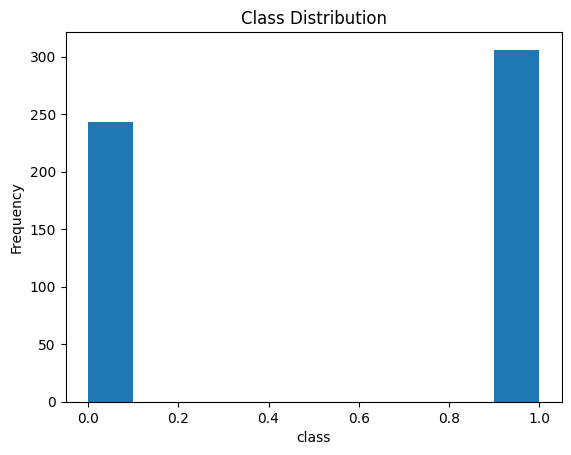

In [5]:
counts, bins = np.histogram(df['AD'])
plt.hist(bins[:-1], bins, weights=counts)
plt.title("Class Distribution")
plt.xlabel('class')
plt.ylabel('Frequency')
print("Class 0 samples: ",len(df[df['AD']==0]))
print("Class 1 samples: ",len(df[df['AD']==1]))
plt.show()

## Preprocess data
1. Clean data
2. remove stop words
3. Apply Stemming (optional)
3. Apply lemmatization (Optional)

In [ ]:
# clean data. Keep only english alphabets

In [6]:
import string

table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
string_punctuation_1 = string.punctuation.replace(".","").replace("`","").replace("'","")
table_ = str.maketrans(string_punctuation_1, ' '*len(string_punctuation_1))
printable = set(string.printable)


def clean_data(text):


    sentence = text.lower()
    sentence_no_punct = sentence.translate(table_)
    space_remove = re.sub('\s+',' ', sentence_no_punct)
    return space_remove


In [ ]:
df['Transcripts_cleaned'] = df['Transcripts'].apply(lambda row: clean_data(row) )

In [ ]:
df['Transcripts_cleaned'].iloc[2051] , df['AD'].iloc[2051]

('water is pouring out of the sink .', 0)

In [ ]:
#stemming data (optional)

In [ ]:
stemmer = SnowballStemmer('english')
def stem_words(text):
    text = text.split()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [ ]:
df['Transcripts_stem'] = df['Transcripts_cleaned'].apply(lambda row: stem_words(row))

In [ ]:
df['Transcripts_stem']

0                           the scene is in the kitchen .
1       the mother is wipe dish and the water is run o...
2       a boy is tri to get cooki out of a jar and he ...
3                   the littl girl is react to his fall .
4                              it seem to be summer out .
                              ...                        
7104      and there postclit some shrub out there and ...
7105    oh â¡ that kid postclit gonna postclit get a ...
7106    gonna postclit drop whatev he postclit got in ...
7107    the littl girl postclit reach up there to get ...
7108    i think he postclit gonna postclit land himsel...
Name: Transcripts_stem, Length: 7109, dtype: object

In [ ]:
#Lemmatizing data (optional)

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df['Transcripts_lem'] = df['Transcripts_cleaned'].apply(lambda row: " ".join([lemmatizer.lemmatize(i) for i in word_tokenize(row)]))

In [ ]:
df['Transcripts_lem']

0                           the scene is in the kitchen .
1       the mother is wiping dish and the water is run...
2       a boy is trying to get cooky out of a jar and ...
3            the little girl is reacting to his falling .
4                             it seems to be summer out .
                              ...                        
7104    and there 's postclitic some shrub out there a...
7105    oh â¡ that kid 's postclitic gon na postcliti...
7106    gon na postclitic drop whatever he 's postclit...
7107    the little girl 's postclitic reaching up ther...
7108    i think he 's postclitic gon na postclitic lan...
Name: Transcripts_lem, Length: 7109, dtype: object

## TF-IDF approach

In [7]:
#transforming sentences to vectors
vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,min_df=5, max_df=0.9)
X = vectorizer.fit_transform(df['clean'].tolist())

In [8]:
X.shape

(549, 376)

In [ ]:
#checking the weights assigned to each word
# Checking the weights assigned to each word

sorted([x for x in zip(vectorizer.get_feature_names_out(), vectorizer.idf_)], key=lambda x:x[1], reverse=True)

[('accident', 5.518158808998462),
 ('actually', 5.518158808998462),
 ('aren', 5.518158808998462),
 ('beginning', 5.518158808998462),
 ('cascading', 5.518158808998462),
 ('closet', 5.518158808998462),
 ('clothes', 5.518158808998462),
 ('dangerous', 5.518158808998462),
 ('dishwashing', 5.518158808998462),
 ('driveway', 5.518158808998462),
 ('drop', 5.518158808998462),
 ('family', 5.518158808998462),
 ('finished', 5.518158808998462),
 ('girls', 5.518158808998462),
 ('grab', 5.518158808998462),
 ('happy', 5.518158808998462),
 ('hard', 5.518158808998462),
 ('hedges', 5.518158808998462),
 ('help', 5.518158808998462),
 ('hmhunh', 5.518158808998462),
 ('imagine', 5.518158808998462),
 ('knows', 5.518158808998462),
 ('laying', 5.518158808998462),
 ('leg', 5.518158808998462),
 ('means', 5.518158808998462),
 ('mommy', 5.518158808998462),
 ('ones', 5.518158808998462),
 ('overflowed', 5.518158808998462),
 ('overrunning', 5.518158808998462),
 ('raising', 5.518158808998462),
 ('roof', 5.51815880899846

In [10]:
X = X.toarray()
y= np.array(df['AD'].tolist())

In [11]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42  )

In [9]:
models_f1 = []
models_f1.append((LogisticRegression()))
# models_f1.append((GridSearchCV(), LinearDiscriminantAnalysis()))
models_f1.append(( KNeighborsClassifier()))
models_f1.append((DecisionTreeClassifier()))
models_f1.append((MultinomialNB()))
models_f1.append((SVC(kernel="linear", C=0.1,probability=True)))
models_f1.append((RandomForestClassifier()))
models_f1.append((AdaBoostClassifier()))

In [ ]:
import pandas as pd
!pip install --upgrade pandas
print(pd.__version__)

2.0.3


LogisticRegression
****Results****
Accuracy: 75.4545%
****F1 score,Precision and recall****
f1_score: 0.7540372670807453 , Precison: 0.7538894405825884, Recall: 0.7543103448275862, Individual_f1: [0.76521739 0.74285714]
(array([0.77192982, 0.73584906]), array([0.75862069, 0.75      ]), array([0.76521739, 0.74285714]), array([58, 52]))
***confusion matrix****


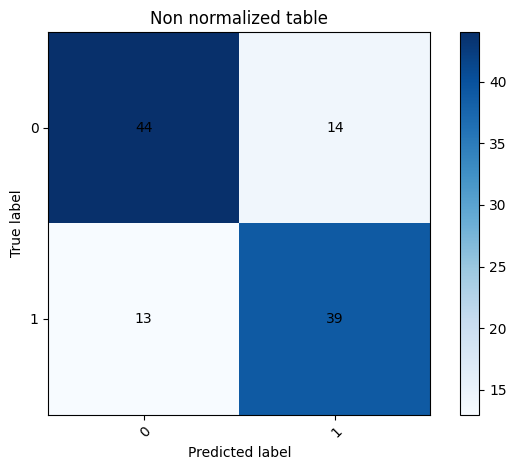

Log Loss: 0.5479112794476656
KNeighborsClassifier
****Results****
Accuracy: 74.5455%
****F1 score,Precision and recall****
f1_score: 0.7348484848484849 , Precison: 0.7680180180180181, Recall: 0.736737400530504, Individual_f1: [0.78787879 0.68181818]
(array([0.7027027 , 0.83333333]), array([0.89655172, 0.57692308]), array([0.78787879, 0.68181818]), array([58, 52]))
***confusion matrix****


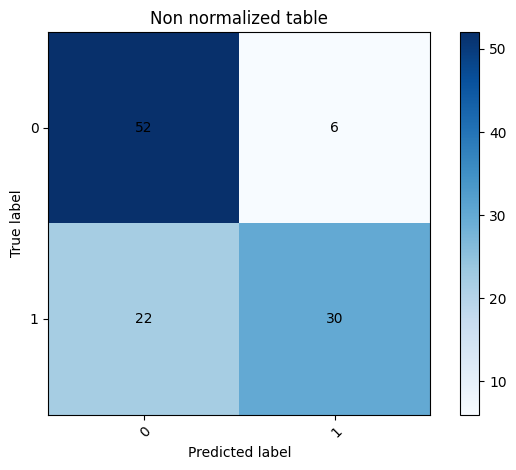

Log Loss: 2.4056872755658256
DecisionTreeClassifier
****Results****
Accuracy: 64.5455%
****F1 score,Precision and recall****
f1_score: 0.6430651468508195 , Precison: 0.6589725789656369, Recall: 0.6518567639257294, Individual_f1: [0.61386139 0.67226891]
(array([0.72093023, 0.59701493]), array([0.53448276, 0.76923077]), array([0.61386139, 0.67226891]), array([58, 52]))
***confusion matrix****


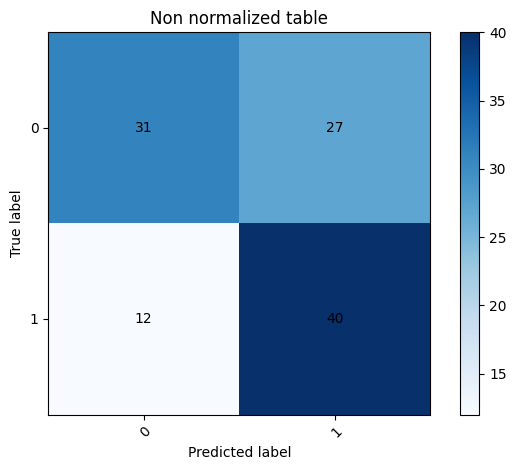

Log Loss: 12.779113474323356
MultinomialNB
****Results****
Accuracy: 64.5455%
****F1 score,Precision and recall****
f1_score: 0.6451906376643786 , Precison: 0.6454545454545455, Recall: 0.6458885941644563, Individual_f1: [0.65486726 0.63551402]
(array([0.67272727, 0.61818182]), array([0.63793103, 0.65384615]), array([0.65486726, 0.63551402]), array([58, 52]))
***confusion matrix****


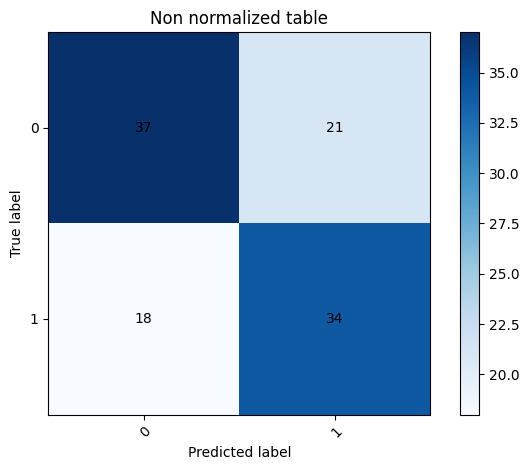

Log Loss: 0.5994956216939699
SVC
****Results****
Accuracy: 48.1818%
****F1 score,Precision and recall****
f1_score: 0.3399305190020002 , Precison: 0.7385321100917431, Recall: 0.5086206896551724, Individual_f1: [0.03389831 0.64596273]
(array([1.        , 0.47706422]), array([0.01724138, 1.        ]), array([0.03389831, 0.64596273]), array([58, 52]))
***confusion matrix****


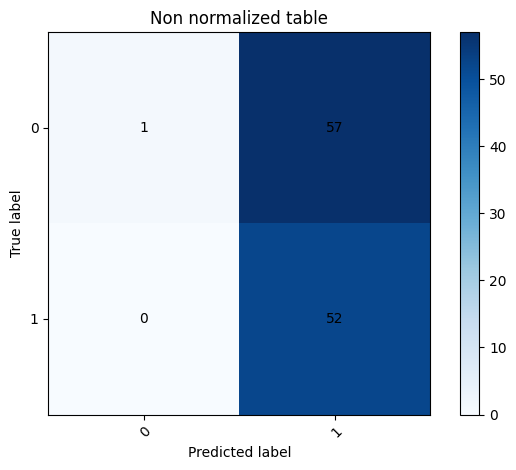

Log Loss: 0.5779266461020175
RandomForestClassifier
****Results****
Accuracy: 76.3636%
****F1 score,Precision and recall****
f1_score: 0.7636363636363636 , Precison: 0.7659151193633953, Recall: 0.7659151193633953, Individual_f1: [0.76363636 0.76363636]
(array([0.80769231, 0.72413793]), array([0.72413793, 0.80769231]), array([0.76363636, 0.76363636]), array([58, 52]))
***confusion matrix****


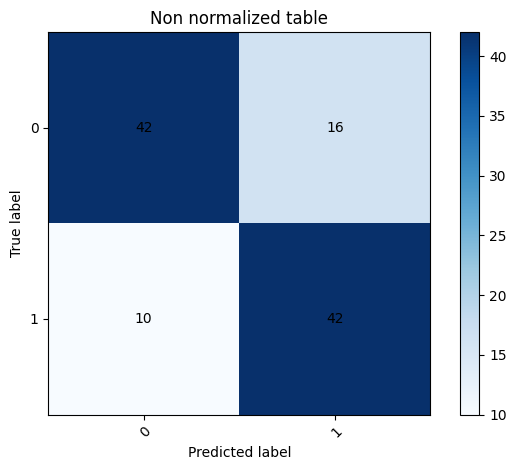

Log Loss: 0.5262453593895106
AdaBoostClassifier
****Results****
Accuracy: 70.9091%
****F1 score,Precision and recall****
f1_score: 0.7087057265806024 , Precison: 0.7086640211640212, Recall: 0.7092175066312998, Individual_f1: [0.71929825 0.69811321]
(array([0.73214286, 0.68518519]), array([0.70689655, 0.71153846]), array([0.71929825, 0.69811321]), array([58, 52]))
***confusion matrix****


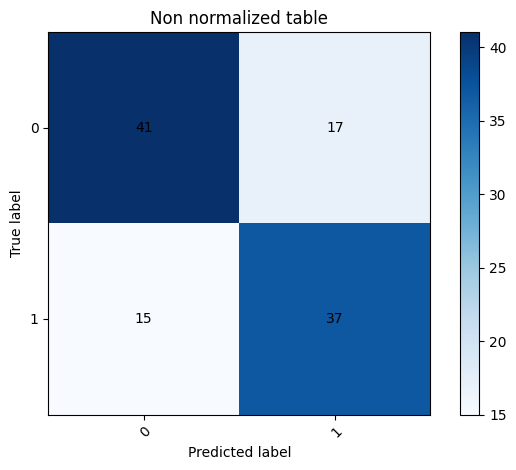

Log Loss: 0.6698252718569856


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
for clf in models_f1:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("="*30)
    print(name)

    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    print('****F1 score,Precision and recall****')
    f1_score = sklearn.metrics.f1_score(y_test, train_predictions,average='macro')
    Precision = sklearn.metrics.precision_score(y_test, train_predictions,average='macro')
    Recall = sklearn.metrics.recall_score(y_test, train_predictions,average='macro')
    individual_f1 = sklearn.metrics.f1_score(y_test, train_predictions, average=None)
    print("f1_score: {} , Precison: {}, Recall: {}, Individual_f1: {}".format(f1_score,Precision,Recall,individual_f1))
    print(precision_recall_fscore_support(y_test, train_predictions, average=None, labels=df['AD'].unique()))
    print('***confusion matrix****')
    classes = df['AD'].unique()
    cm = confusion_matrix(y_test, train_predictions)
    fig, ax = plt.subplots()
    cmap=plt.cm.Blues
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title="Non normalized table",
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    normalize = False
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 3.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="black")
    fig.tight_layout()
    plt.show()

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = pd.concat([log, log_entry])

### Grid Search + SVM

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import joblib
svc = SVC(probability=True)
parameters = {'kernel':('linear','rbf'), 'C':[0.01, 10]}
model = GridSearchCV(svc,parameters)
model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

labels = [0, 1]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average=None, labels= labels))


GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.01, 10], 'kernel': ('linear', 'rbf')})
0.7818181818181819
[[47 11]
 [13 39]]
(array([0.78333333, 0.78      ]), array([0.81034483, 0.75      ]), array([0.79661017, 0.76470588]), array([58, 52]))


In [16]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80        58
           1       0.78      0.75      0.76        52

    accuracy                           0.78       110
   macro avg       0.78      0.78      0.78       110
weighted avg       0.78      0.78      0.78       110



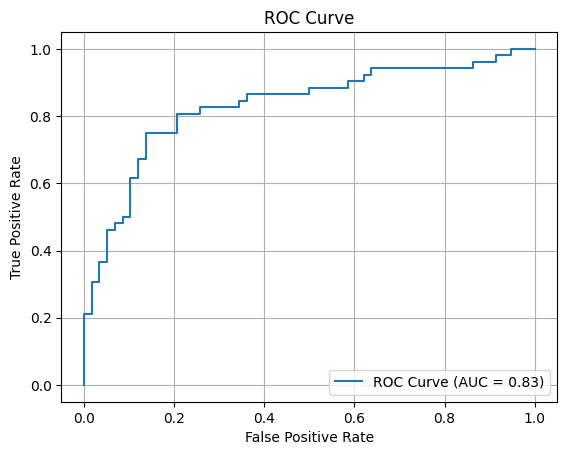

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_probas = model.predict_proba(X_test)[:, 1]  # Assuming binary classification

fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = roc_auc_score(y_test, y_probas)  # Calculate AUC

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')  # Add legend with AUC value
plt.grid(True)  # Add grid for better readability

plt.show()


Random Forest

In [18]:
rf_classifier = RandomForestClassifier()

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_search.best_params_

# Train final model with best hyperparameters
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train)


RandomForestClassifier(min_samples_split=10, n_estimators=200)

In [19]:
y_pred = final_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

labels = [0, 1]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average=None, labels= labels))

0.7727272727272727
[[41 17]
 [ 8 44]]
(array([0.83673469, 0.72131148]), array([0.70689655, 0.84615385]), array([0.76635514, 0.77876106]), array([58, 52]))


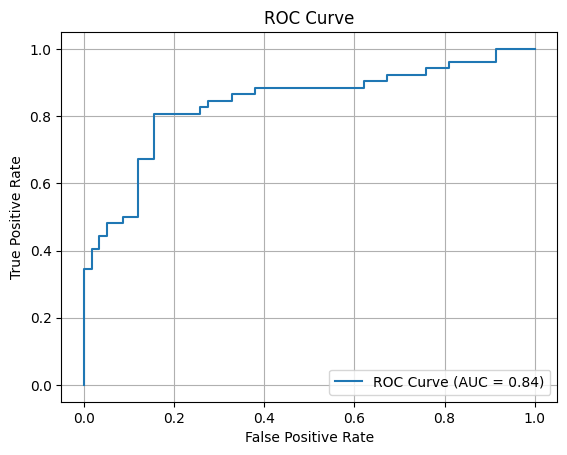

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_probas = final_model.predict_proba(X_test)[:, 1]  # Assuming binary classification

fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = roc_auc_score(y_test, y_probas)  # Calculate AUC

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')  # Add legend with AUC value
plt.grid(True)  # Add grid for better readability

plt.show()

In [23]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        58
           1       0.72      0.85      0.78        52

    accuracy                           0.77       110
   macro avg       0.78      0.78      0.77       110
weighted avg       0.78      0.77      0.77       110



Decision Tree

In [ ]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
print(model_dt)
y_pred = model_dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)

labels = [0, 1]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average=None, labels= labels))
print(classification_report(y_test,y_pred))

DecisionTreeClassifier()
0.5909090909090909
[[28 30]
 [15 37]]
(array([0.65116279, 0.55223881]), array([0.48275862, 0.71153846]), array([0.55445545, 0.62184874]), array([58, 52]))
              precision    recall  f1-score   support

           0       0.65      0.48      0.55        58
           1       0.55      0.71      0.62        52

    accuracy                           0.59       110
   macro avg       0.60      0.60      0.59       110
weighted avg       0.60      0.59      0.59       110



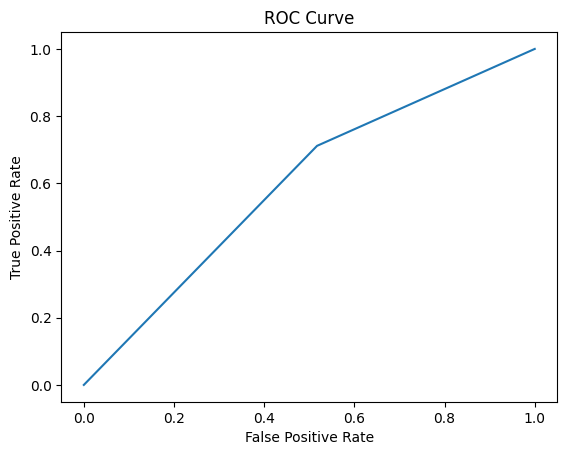

In [ ]:
from sklearn.metrics import roc_curve , roc_auc_score
y_probas = model_dt.predict_proba(X_test)[:,1]
#skplt.metrics.plot_roc_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

Deep learning

In [24]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Dropout,Conv1D, Flatten, MaxPooling1D, Dense, LSTM,Conv1D,MaxPooling1D, Bidirectional
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import History

%matplotlib inline

In [25]:
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(df['clean'], df['AD'], test_size = 0.1, random_state = 0)

In [49]:
tokenizer = Tokenizer(num_words = 2500)
tokenizer.fit_on_texts(X_seq_train)

Xwords_train = tokenizer.texts_to_sequences(X_seq_train)
Xwords_test = tokenizer.texts_to_sequences(X_seq_test)

In [50]:
max_review_length = 100
Xwords_train = sequence.pad_sequences(Xwords_train, maxlen=max_review_length)
Xwords_test = sequence.pad_sequences(Xwords_test, maxlen=max_review_length)

In [51]:
print(Xwords_train.shape)
print(Xwords_test.shape)
print(y_seq_train.shape)
print(y_seq_test.shape)

(494, 100)
(55, 100)
(494,)
(55,)


In [29]:
vocab = len(tokenizer.word_index) + 1   # Add one for the zero indexing
vocab

1642

In [30]:
#setting history parameter to record accuracy and loss info of model

history = History()

In [31]:
model = Sequential()
model.add(Embedding(input_dim = vocab, output_dim = 100, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(Xwords_train, y_seq_train, epochs=50, batch_size=256,verbose = 1,callbacks = [history],validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          164200    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 281577 (1.07 MB)
Trainable params: 281577 (1.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
2/2 [==============================] - 9s 1s/step - loss: 0.6928 - accuracy: 0.4887 - val_loss: 0.6897 - val_accuracy: 0.6000
Epoch 2/50
2/2 [==============================] - 2s 881ms/step - loss: 0.6884 - accuracy: 0.5518 - val_loss: 0.6851 - val_accuracy: 0.6000
Ep

In [36]:
eval_list = model.evaluate(Xwords_test,y_seq_test)
print('Test Loss: ',eval_list[0])
print('Test Accuracy: ',eval_list[1])

2/2 [==============================] - 0s 95ms/step - loss: 0.9922 - accuracy: 0.7091
Test Loss:  0.9922459125518799
Test Accuracy:  0.7090908885002136


2/2 [==============================] - 1s 60ms/step


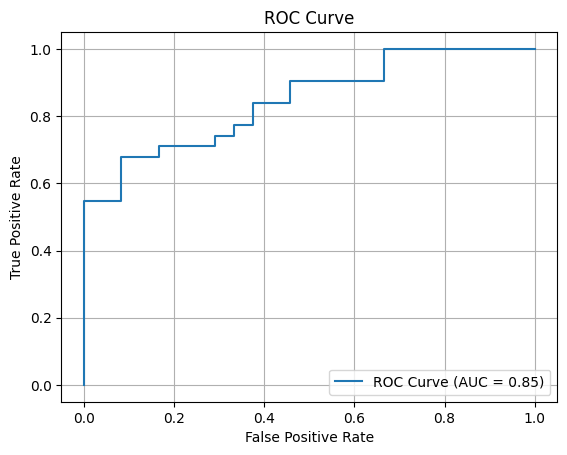

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming binary classification
y_pred_probas = model.predict(Xwords_test)
# Extract probabilities for the positive class (modify if needed)

fpr, tpr, thresholds = roc_curve(y_seq_test, y_pred_probas)
roc_auc = roc_auc_score(y_seq_test, y_pred_probas)  # Calculate AUC

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')  # Add legend with AUC value
plt.grid(True)  # Add grid for better readability

plt.show()


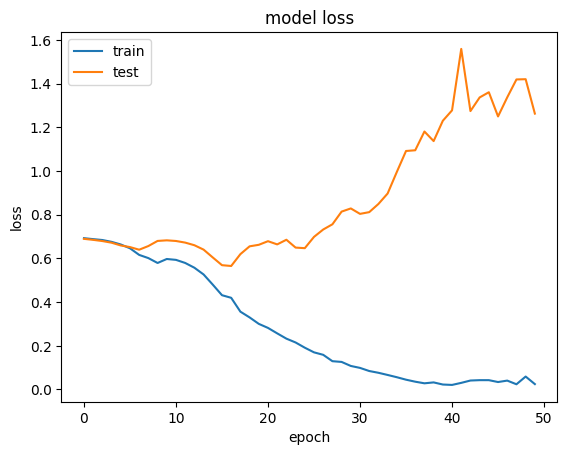

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

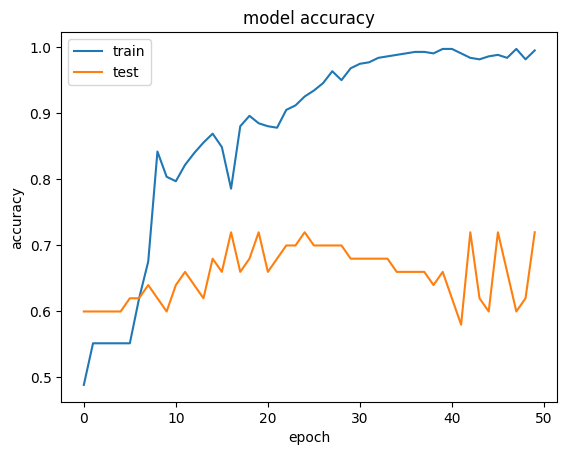

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Bidirectional LSTM

In [52]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim = vocab, output_dim = 100, input_length=100))
model_bilstm.add(Bidirectional(LSTM(128, recurrent_dropout=0.2)))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_bilstm.summary())

model_bilstm.fit(Xwords_train, y_seq_train, epochs=50, batch_size=256,verbose = 1,callbacks = [history],validation_split=0.1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          164200    
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 398953 (1.52 MB)
Trainable params: 398953 (1.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
2/2 [==============================] - 12s 3s/step - loss: 0.6919 - accuracy: 0.5045 - val_loss: 0.6834 - val_accuracy: 0.6000
Epoch 2/50
2/2 [==============================] - 3s 2s/step - loss: 0.68

In [64]:
eval_list = model_bilstm.evaluate(Xwords_test,y_seq_test)
print('Test Loss: ',eval_list[0])
print('Test Accuracy: ',eval_list[1])

2/2 [==============================] - 0s 63ms/step - loss: 1.4685 - accuracy: 0.7273
Test Loss:  1.4684697389602661
Test Accuracy:  0.7272727489471436


In [54]:
model_bilstm.save('saved_models/model_bilstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 62ms/step


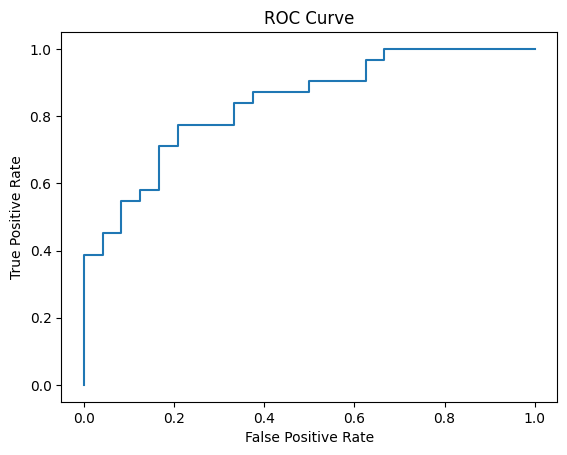

In [57]:
y_pred_probas = model_bilstm.predict(Xwords_test)
y_pred_probas = [i[0] for i in y_pred_probas]
fpr, tpr, thresholds = roc_curve(y_seq_test, y_pred_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

2/2 [==============================] - 0s 140ms/step


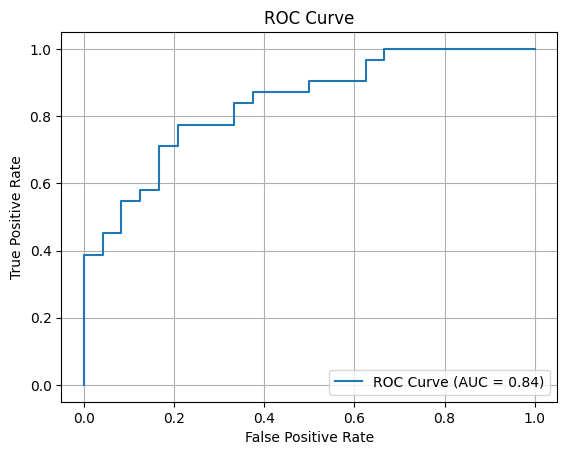

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming binary classification
y_pred_probas = model_bilstm.predict(Xwords_test)
# Extract probabilities for the positive class (modify if needed)

fpr, tpr, thresholds = roc_curve(y_seq_test, y_pred_probas)
roc_auc = roc_auc_score(y_seq_test, y_pred_probas)  # Calculate AUC

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')  # Add legend with AUC value
plt.grid(True)  # Add grid for better readability

plt.show()

In [60]:
# Predict probabilities on test data
y_pred_prob = model_bilstm.predict(Xwords_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

2/2 [==============================] - 0s 58ms/step


In [61]:
print(confusion_matrix(y_seq_test, y_pred))
print(classification_report(y_seq_test,y_pred))

[[24  0]
 [31  0]]
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        24
           1       0.00      0.00      0.00        31

    accuracy                           0.44        55
   macro avg       0.22      0.50      0.30        55
weighted avg       0.19      0.44      0.27        55



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


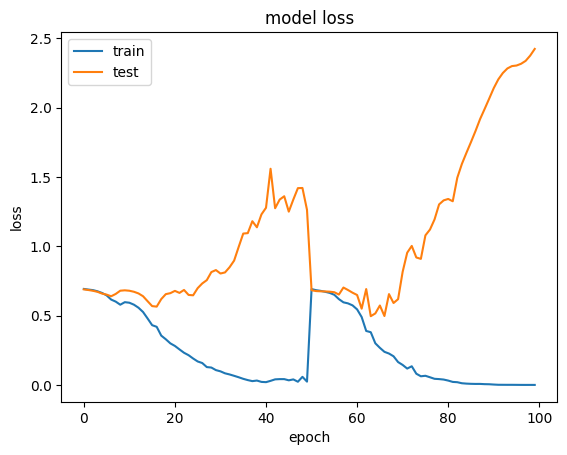

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

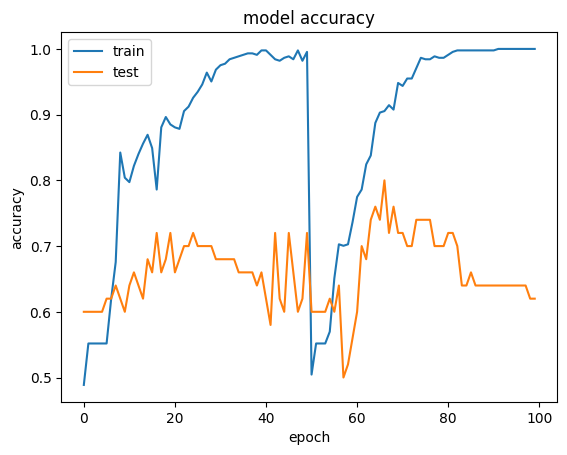

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()